# Bayesian Modelling

# TODO

- Single var binomial, gaussian, poisson
- Multi var above
- MCMC
- SBI / ABC
- LAN?


In [8]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

# Beta-Binomial conjugate

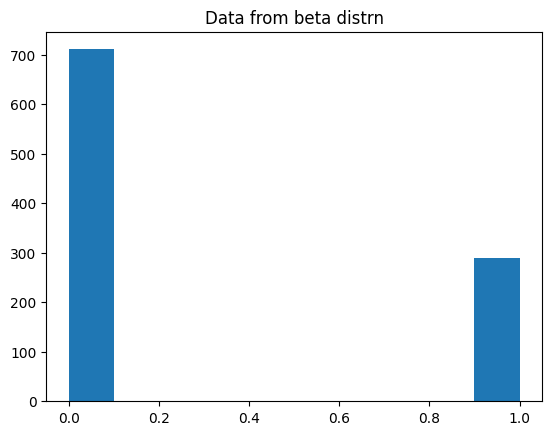

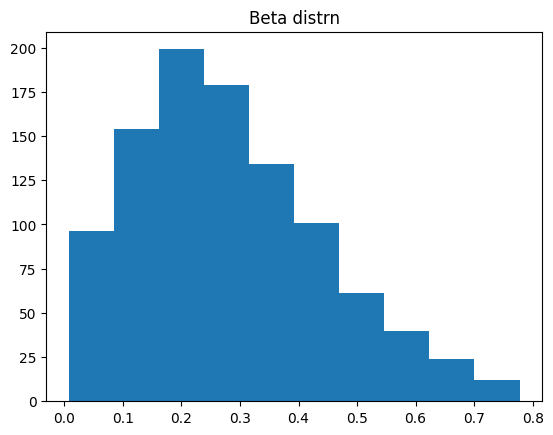

In [3]:
alpha = 2; beta = 5
N = 1000
random_beta_distr = np.random.beta(alpha, beta, N)
random_data = np.random.binomial(1, random_beta_distr, N)

plt.hist(random_data);  plt.title('Data from beta distrn'); plt.show()
plt.hist(random_beta_distr); plt.title('Beta distrn'); plt.show()


## Derivation of alpha posterior, beta posterior

We assume:
1.  the probabilities of parameters(**Priors**) are picked from Beta-Distribution
2. The Distribution of *data given the parameters*(**likelihood**) is picked from Binomial distribution

## Priors come from Beta Distribution
$ \pi(\theta) = \theta^{\alpha - 1} \cdot (1 - \theta)^{\beta - 1}$ 

RHS divided by Normalizing constant, which is ignored

## Likelihood

$ \pi(\frac{X}{\theta}) = \binom{N}{X} \cdot \theta^{X} \cdot (1 - \theta)^{N - X}  $ 

(X is number of successful trials)

## Posterior
$
\begin{align*}
    \pi\left(\frac{\theta}{X}\right) &= \pi\left(\frac{X}{\theta}\right) \cdot \pi(\theta) \\
    &= \binom{N}{X} \cdot \theta^X \cdot (1 - \theta)^{N - X} \cdot \theta^{\alpha - 1} \cdot (1 - \theta)^{\beta - 1} \\
    &= \theta^{\alpha + X - 1} \cdot (1 - \theta)^{\beta + N - X - 1} \cdot NormalizingConst
\end{align*}

$


Since, new posteriors are also from beta-distribution(the idea of conjugate that prior and posterior are from same distribution)
new params

$ \alpha = \alpha + X $ (where X is number of successful trials) 


$ \beta = \beta +  N - X $ (where N is number of trials) 

In [10]:
# Priors
alpha_prior = 1
beta_prior = 1

In [11]:
# Update Posteriors' based on above derivation
X = np.sum(random_data)
alpha_post = alpha_prior + X
beta_post = beta_prior + N - X 

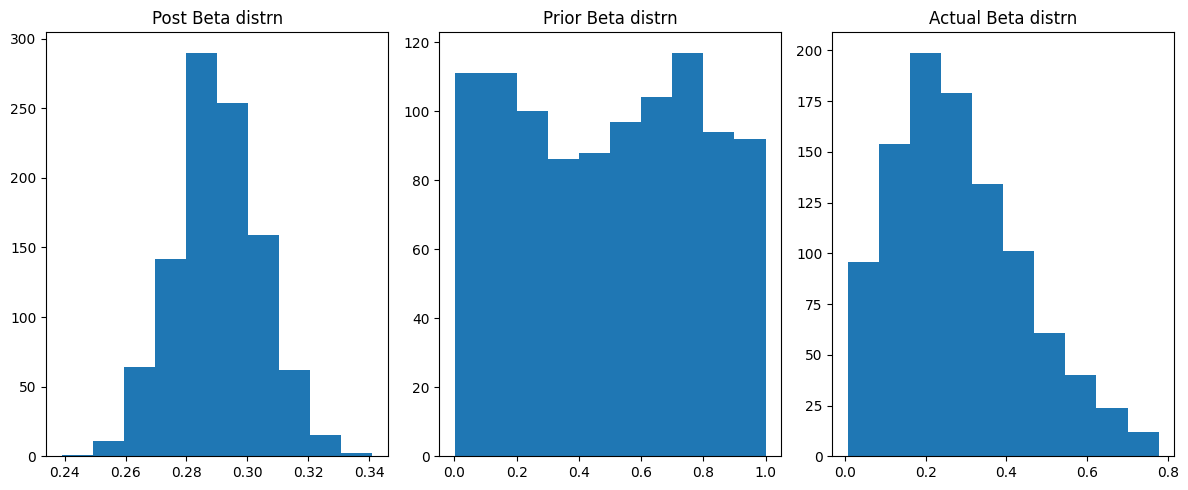

In [17]:
prior_prob = np.random.beta(alpha_prior, beta_prior, N)
posterior_prob = np.random.beta(alpha_post, beta_post, N)

fig, ax = plt.subplots(1, 3, figsize=(12, 5))

ax[0].hist(posterior_prob);ax[0].set_title('Post Beta distrn')
ax[1].hist(prior_prob); ax[1].set_title('Prior Beta distrn')
ax[2].hist(random_beta_distr);ax[2].set_title('Actual Beta distrn')

plt.tight_layout();plt.show()

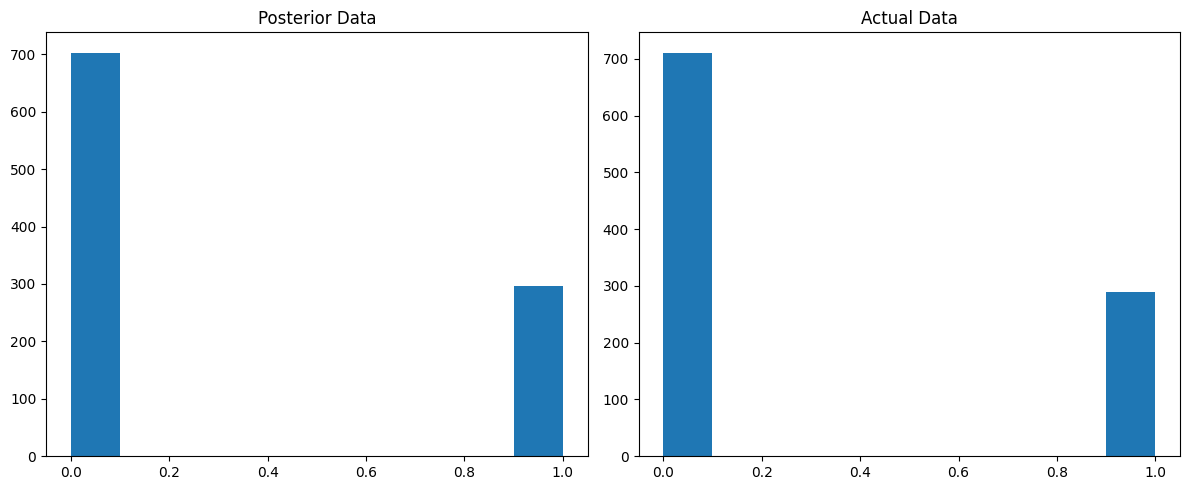

In [16]:
posterior_data = np.random.binomial(1, posterior_prob, N)
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].hist(posterior_data);ax[0].set_title('Posterior Data')
ax[1].hist(random_data); ax[1].set_title('Actual Data')

plt.tight_layout();plt.show()

## Similarly, for Poisson-Gamma Conjugate

**Priors come from Gamma Distr**

$ \frac{\beta^\alpha}{\Gamma(k)} \cdot \lambda^{\alpha-1} e^{-\beta \lambda}$ 

**Likelihood from possion(Since independent, Prob of observing **X** vector data is product of independent poisson prob)**

$ \pi(\frac{\textbf{x}}{\lambda}) = Likelihood = \prod_{i=1}^{N} \frac{e^{-\lambda}  \cdot \lambda^{x_i}}{x_i !}  = \frac{e^{-\lambda \cdot N} \cdot \lambda^{\sum_{i} X}}{\prod_{i} x_i !}$

**Posterior**
Posterior = Likelihood X Prior

$ Posterior = \lambda^{\alpha + \sum_{i} x - 1} \cdot e^{-\lambda{(\beta + N)}}$



Conjugate assumption: The posteriors are also from Gamma distribution with NEW parameters being

$  \lambda = \beta + N $

$ \alpha = \alpha + \sum_{i} x $ 

## For Normal, its a bit complicated
https://people.eecs.berkeley.edu/~jordan/courses/260-spring10/lectures/lecture5.pdf

## MCMC

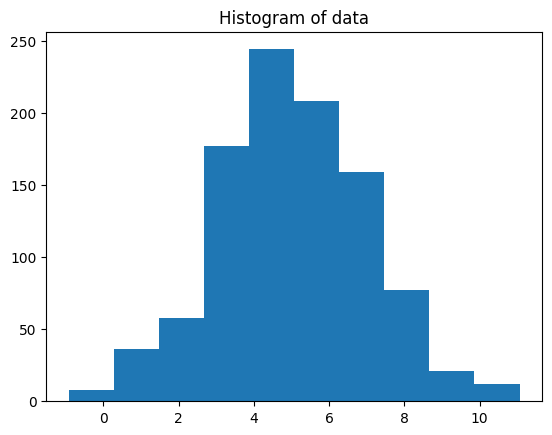

In [3]:
# Generate data
mu = 5; sigma = 2
N = 1000

data = np.random.normal(mu, sigma, N)

plt.hist(data); plt.title('Histogram of data'); plt.show()

## Pseudocode
1. Assuming **Normal distr**(You have to have some model of the data). Guess the Initial values of the parameters: $ \mu_0, \sigma_0 $
2. For each simulation:
    0. Current point is $\mu, \sigma$
    1. Propose a new point in plane: $\mu', \sigma' $ picking from $ N(\mu, \sigma_{\mu}) $ and $ N(\sigma, \sigma_{\sigma}) $  respectively
    2. Calculate the `ratio`: Likelihood(Data/$\mu', \sigma' $)/Likelihood(Data/$\mu, \sigma $)
    3.  Generate a random number between 0 and 1: `u`
    4. If u is between 0 and `ratio`, then $\mu, \sigma -> \mu', \sigma'$  
    5. If not, then stay at the same place.

In [15]:
# params

# initial points - mu and sigma at t = 0
mu_0 = 1; sigma_0 = 1

# std of the proposed mean and sigma
sigma_mu = 0.5; sigma_sigma = 0.5

# number of simulations
N = 100

In [16]:
def log_likelihood(x, mu, sigma):
    """
    x is the data vector
    we want to calculate P(Data/params) = P(X/mu, sigma) = P(x1/mu,sigma) x P(x2/mu,sigma) x ... P(xn/mu,sigma)
    """

    return np.sum(np.log(1/(np.sqrt(2*np.pi*sigma**2))*np.exp(-(x-mu)**2/(2*sigma**2))))
    
    

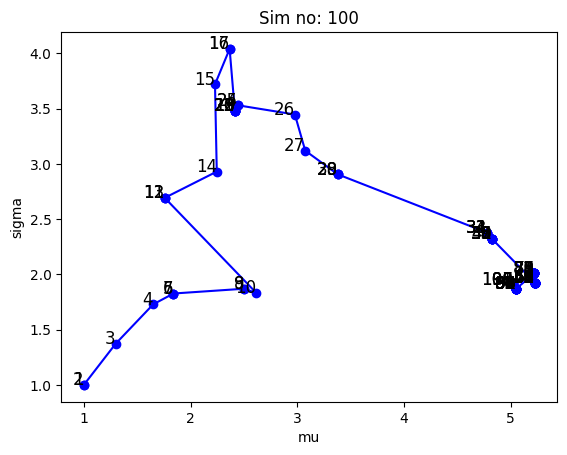

In [17]:
# current param
mu = mu_0; sigma = sigma_0
all_traversed_params = [ (mu, sigma) ]

for sim_no in range(N):
    # sample new mu and sigma from Normal distr
    # mu ~ N(mu(t), SIGMA_MU), sigma ~ N(sigma(t), SIGMA_SIGMA). the SIGMAs are params chosen by us
    mu_prime = np.random.normal(mu, sigma_mu)
    sigma_prime = np.random.normal(sigma, sigma_sigma)
    
    # likelikhood of new point
    p_prime = log_likelihood(data, mu_prime, sigma_prime)
    p_current = log_likelihood(data, mu, sigma)

    if p_prime >= p_current:
        # accept new point
        mu = mu_prime
        sigma = sigma_prime
    else:
        # accept the point with prob P_prime/P_current
        # this will help the param to NOT get stuck at local minima, else params will be stuck
        u = np.random.uniform(0, 1)
        if np.exp(p_prime)/np.exp(p_current) < u:
            mu = mu_prime
            sigma = sigma_prime
        else:
            mu = mu
            sigma = sigma
    
    all_traversed_params.append((mu, sigma))


    clear_output(wait=True)
    mu_values = [mu for mu, sigma in all_traversed_params]
    sigma_values = [sigma for mu, sigma in all_traversed_params]
    plt.plot(mu_values, sigma_values, 'bo-', label='Traversal Path')
    for i, (mu, sigma) in enumerate(all_traversed_params):
        plt.text(mu, sigma, f'{i+1}', fontsize=12, ha='right')

    plt.xlabel('mu');  plt.ylabel('sigma'); plt.title(f'Sim no: {sim_no + 1}'); plt.show()

    

      

In [18]:
all_traversed_params[-1]
# original: mu = 5; sigma = 2

(5.019237119688174, 1.9106690983198333)